In [1]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

In [2]:
# Helper function
def show_images(image, num_row=2, num_col=5):
    # plot images
    image_size = int(np.sqrt(image.shape[-1]))
    image = np.reshape(image, (image.shape[0], image_size, image_size))
    fig, axes = plt.subplots(num_row, num_col, figsize=(1.5*num_col,2*num_row))
    for i in range(num_row*num_col):
        ax = axes[i//num_col, i%num_col]
        ax.imshow(image[i], cmap='gray', vmin=0, vmax=1)
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
def one_hot(x, k, dtype=np.float32):
    """Create a one-hot encoding of x of size k."""
    return np.array(x[:, None] == np.arange(k), dtype)

**Dataset preparation**

In [3]:
#Loading
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize data 

x_train= x_train / 255.0
x_test = x_test / 255.0
 
# One-hot encode labels
num_labels = 10
y_train=one_hot(y_train.astype('int32'),num_labels)
y_test=one_hot(y_test.astype('int32'),num_labels)


x_train = x_train.reshape(60000,28*28)
x_test = x_test.reshape(10000,28*28)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Training data: (60000, 784) (60000, 10)
Test data: (10000, 784) (10000, 10)


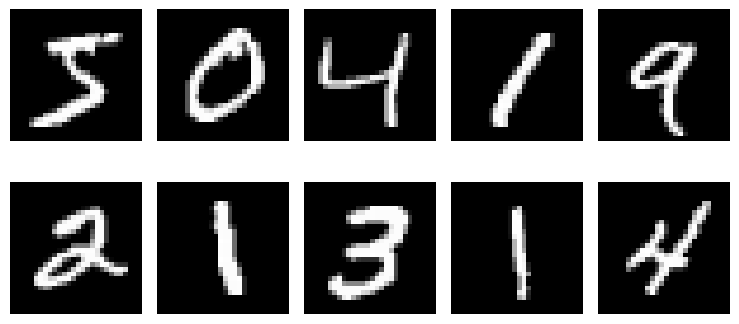

In [4]:
print("Training data: {} {}".format(x_train.shape, y_train.shape))
print("Test data: {} {}".format(x_test.shape, y_test.shape))
show_images(x_train)

**Initialization**

In [5]:
class DeepNeuralNetwork():
    def __init__(self, sizes, activation='sigmoid'):
        self.sizes = sizes
        
        # Choose activation function
        if activation == 'relu':
            self.activation = self.relu
        elif activation == 'sigmoid':
            self.activation = self.sigmoid
        else:
            raise ValueError("Activation function is currently not support, please use 'relu' or 'sigmoid' instead.")
        
        # Save all weights
        self.params = self.initialize()
        # Save all intermediate values, i.e. activations
        self.cache = {}
        # Momentum için
        self.momemtum_opt = {key: np.zeros_like(value) for key, value in self.params.items()}

        # RMSProp için
        self.rmsprop_cache = {key: np.zeros_like(value) for key, value in self.params.items()}

        # Adam için
        self.adam_m = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.adam_v = {key: np.zeros_like(value) for key, value in self.params.items()}
        self.t = 1  # Başlangıç iterasyon sayısı

        
    def relu(self, x, derivative=False):
        '''
            Derivative of ReLU is a bit more complicated since it is not differentiable at x = 0
        
            Forward path:
            relu(x) = max(0, x)
            In other word,
            relu(x) = 0, if x < 0
                    = x, if x >= 0

            Backward path:
            ∇relu(x) = 0, if x < 0
                     = 1, if x >=0
        '''
        if derivative:
            x = np.where(x < 0, 0, x)
            x = np.where(x >= 0, 1, x)
            return x
        return np.maximum(0, x)


    def sigmoid(self, x, derivative=False):
        '''
            Forward path:
            σ(x) = 1 / 1+exp(-z)
            
            Backward path:
            ∇σ(x) = exp(-z) / (1+exp(-z))^2
        '''
        x = np.clip(x, -500, 500)
        if derivative:
            sig = 1 / (1 + np.exp(-x))
            return sig * (1 - sig)
        return 1 / (1 + np.exp(-x))
    
    def softmax(self, x):
        '''
            softmax(x) = exp(x) / ∑exp(x)
        '''
        # Numerically stable with large exponentials
        x = x - np.max(x, axis=0, keepdims=True)
        exps = np.exp(x)
        return exps / np.sum(exps, axis=0, keepdims=True)


    def initialize(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_layer=self.sizes[1]
        output_layer=self.sizes[2]
        
        return {
            "W1": np.random.randn(hidden_layer, input_layer) * np.sqrt(2. / input_layer),  # He initialization
            "b1": np.zeros((hidden_layer, 1)),
            "W2": np.random.randn(output_layer, hidden_layer) * np.sqrt(2. / hidden_layer),  # He initialization
            "b2": np.zeros((output_layer, 1))
        }
    
    def initialize_momemtum_optimizer(self):
        momemtum_opt = {
            "W1": np.zeros(self.params["W1"].shape),
            "b1": np.zeros(self.params["b1"].shape),
            "W2": np.zeros(self.params["W2"].shape),
            "b2": np.zeros(self.params["b2"].shape),
        }
        return momemtum_opt

    def feed_forward(self, x):
        '''
            y = σ(wX + b)
        '''
        self.cache["X"] = x
        self.cache["Z1"] = np.matmul(self.params["W1"], self.cache["X"].T) + self.params["b1"]
        self.cache["A1"] = self.activation(self.cache["Z1"])
        self.cache["Z2"] = np.matmul(self.params["W2"], self.cache["A1"]) + self.params["b2"]
        self.cache["A2"] = self.softmax(self.cache["Z2"])
        return self.cache["A2"]
    def back_propagate(self, y, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        current_batch_size = y.shape[0]
        
        dZ2 = output - y.T
        dW2 = (1./current_batch_size) * np.matmul(dZ2, self.cache["A1"].T)
        db2 = (1./current_batch_size) * np.sum(dZ2, axis=1, keepdims=True)

        dA1 = np.matmul(self.params["W2"].T, dZ2)
        dZ1 = dA1 * self.activation(self.cache["Z1"], derivative=True)
        dW1 = (1./current_batch_size) * np.matmul(dZ1, self.cache["X"])
        db1 = (1./current_batch_size) * np.sum(dZ1, axis=1, keepdims=True)

        self.grads = {"W1": dW1, "b1": db1, "W2": dW2, "b2": db2}
        return self.grads
    
    def cross_entropy_loss(self, y, output):
        '''
            L(y, ŷ) = −∑ylog(ŷ).
        '''
        epsilon = 1e-12  # Küçük bir sabit ekleyerek log(0)'ı önler
        output = np.clip(output, epsilon, 1. - epsilon)  # Çıktıyı sınırla
        l_sum = np.sum(np.multiply(y.T, np.log(output)))
        m = y.shape[0]
        l = -(1./m) * l_sum
        return l
    def optimize_rmsprop(self, l_rate=0.001, beta=0.9, epsilon=1e-8):
        for key in self.params:
            self.rmsprop_cache[key] = beta * self.rmsprop_cache[key] + (1 - beta) * (self.grads[key] ** 2)
            self.params[key] -= l_rate * self.grads[key] / (np.sqrt(self.rmsprop_cache[key]) + epsilon)
    def optimize_adam(self, l_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        for key in self.params:
            self.adam_m[key] = beta1 * self.adam_m[key] + (1 - beta1) * self.grads[key]
            self.adam_v[key] = beta2 * self.adam_v[key] + (1 - beta2) * (self.grads[key] ** 2)
        
            m_hat = self.adam_m[key] / (1 - beta1 ** self.t)
            v_hat = self.adam_v[key] / (1 - beta2 ** self.t)
        
            self.params[key] -= l_rate * m_hat / (np.sqrt(v_hat) + epsilon)
        self.t += 1
                
    def optimize(self, l_rate=0.1, beta=.9, beta1=0.9, beta2=0.999, epsilon=1e-8):
        '''
            Stochatic Gradient Descent (SGD):
            θ^(t+1) <- θ^t - η∇L(y, ŷ)
            
            Momentum:
            v^(t+1) <- βv^t + (1-β)∇L(y, ŷ)^t
            θ^(t+1) <- θ^t - ηv^(t+1)
        '''
        if self.optimizer == "sgd":
            for key in self.params:
                self.params[key] = self.params[key] - l_rate * self.grads[key]
        elif self.optimizer == "momentum":
            for key in self.params:
                self.momemtum_opt[key] = (beta * self.momemtum_opt[key] + (1. - beta) * self.grads[key])
                self.params[key] = self.params[key] - l_rate * self.momemtum_opt[key]
        elif self.optimizer == "RMSProp":
            self.optimize_rmsprop(l_rate=l_rate, beta=beta, epsilon=epsilon)
        elif self.optimizer == "adam":
            self.optimize_adam(l_rate=l_rate, beta1=beta1, beta2=beta2, epsilon=epsilon)
    def accuracy(self, y, output):
        return np.mean(np.argmax(y, axis=-1) == np.argmax(output.T, axis=-1))

    def train(self, x_train, y_train, x_test, y_test, epochs=10, 
              batch_size=64, optimizer='momentum', l_rate=0.1, beta=.9):
        # Hyperparameters
        self.epochs = epochs
        self.batch_size = batch_size
        num_batches = -(-x_train.shape[0] // self.batch_size)
        
        # Initialize optimizer
        self.optimizer = optimizer
        if self.optimizer == 'momentum':
            self.momemtum_opt = self.initialize_momemtum_optimizer()
        
        start_time = time.time()
        template = "Epoch {}: {:.2f}s, train acc={:.2f}, train loss={:.2f}, test acc={:.2f}, test loss={:.2f}"
        
        # Train
        for i in range(self.epochs):
            # Shuffle
            permutation = np.random.permutation(x_train.shape[0])
            x_train_shuffled = x_train[permutation]
            y_train_shuffled = y_train[permutation]

            for j in range(num_batches):
                # Batch
                begin = j * self.batch_size
                end = min(begin + self.batch_size, x_train.shape[0]-1)
                x = x_train_shuffled[begin:end]
                y = y_train_shuffled[begin:end]
                
                # Forward
                output = self.feed_forward(x)
                # Backprop
                grad = self.back_propagate(y, output)
                # Optimize
                self.optimize(l_rate=l_rate, beta=beta)

            # Evaluate performance
            # Training data
            output = self.feed_forward(x_train)
            train_acc = self.accuracy(y_train, output)
            train_loss = self.cross_entropy_loss(y_train, output)
            # Test data
            output = self.feed_forward(x_test)
            test_acc = self.accuracy(y_test, output)
            test_loss = self.cross_entropy_loss(y_test, output)
            print(template.format(i+1, time.time()-start_time, train_acc, train_loss, test_acc, test_loss))

In [6]:
# Sigmoid + Momentum
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='momentum', l_rate=4, beta=.9)

Epoch 1: 1.43s, train acc=0.95, train loss=0.17, test acc=0.94, test loss=0.18
Epoch 2: 2.85s, train acc=0.97, train loss=0.11, test acc=0.96, test loss=0.13
Epoch 3: 4.22s, train acc=0.98, train loss=0.08, test acc=0.96, test loss=0.11
Epoch 4: 5.58s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.10
Epoch 5: 7.01s, train acc=0.98, train loss=0.05, test acc=0.97, test loss=0.09
Epoch 6: 8.40s, train acc=0.98, train loss=0.05, test acc=0.97, test loss=0.09
Epoch 7: 9.81s, train acc=0.99, train loss=0.04, test acc=0.97, test loss=0.09
Epoch 8: 11.22s, train acc=0.99, train loss=0.03, test acc=0.97, test loss=0.08
Epoch 9: 12.60s, train acc=0.99, train loss=0.03, test acc=0.97, test loss=0.08
Epoch 10: 14.00s, train acc=0.99, train loss=0.02, test acc=0.97, test loss=0.09


In [7]:
# Sigmoid + sgd
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=4)

Epoch 1: 1.30s, train acc=0.93, train loss=0.23, test acc=0.93, test loss=0.24
Epoch 2: 2.60s, train acc=0.96, train loss=0.15, test acc=0.95, test loss=0.16
Epoch 3: 4.72s, train acc=0.96, train loss=0.12, test acc=0.96, test loss=0.14
Epoch 4: 6.20s, train acc=0.97, train loss=0.10, test acc=0.96, test loss=0.13
Epoch 5: 7.50s, train acc=0.97, train loss=0.09, test acc=0.96, test loss=0.13
Epoch 6: 8.80s, train acc=0.97, train loss=0.09, test acc=0.96, test loss=0.13
Epoch 7: 10.10s, train acc=0.98, train loss=0.08, test acc=0.96, test loss=0.12
Epoch 8: 11.40s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.11
Epoch 9: 12.70s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.11
Epoch 10: 14.02s, train acc=0.98, train loss=0.06, test acc=0.97, test loss=0.11


In [8]:
# ReLU + SGD
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='sgd', l_rate=0.05)

Epoch 1: 0.94s, train acc=0.89, train loss=0.39, test acc=0.90, test loss=0.38
Epoch 2: 1.91s, train acc=0.91, train loss=0.33, test acc=0.91, test loss=0.31
Epoch 3: 2.91s, train acc=0.91, train loss=0.30, test acc=0.92, test loss=0.29
Epoch 4: 3.88s, train acc=0.92, train loss=0.29, test acc=0.92, test loss=0.28
Epoch 5: 4.87s, train acc=0.92, train loss=0.28, test acc=0.92, test loss=0.27
Epoch 6: 5.86s, train acc=0.92, train loss=0.27, test acc=0.92, test loss=0.27
Epoch 7: 6.84s, train acc=0.93, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 8: 7.82s, train acc=0.93, train loss=0.26, test acc=0.93, test loss=0.26
Epoch 9: 8.84s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25
Epoch 10: 9.84s, train acc=0.93, train loss=0.25, test acc=0.93, test loss=0.25


In [9]:
# Sigmoid + RSMProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='RMSProp', l_rate=2)

Epoch 1: 1.56s, train acc=0.67, train loss=5.50, test acc=0.66, test loss=5.47
Epoch 2: 3.21s, train acc=0.68, train loss=5.96, test acc=0.69, test loss=5.80
Epoch 3: 4.84s, train acc=0.61, train loss=7.34, test acc=0.61, test loss=7.22
Epoch 4: 6.50s, train acc=0.72, train loss=5.05, test acc=0.73, test loss=4.84
Epoch 5: 8.13s, train acc=0.68, train loss=6.95, test acc=0.68, test loss=6.94
Epoch 6: 9.86s, train acc=0.78, train loss=4.22, test acc=0.79, test loss=3.85
Epoch 7: 11.55s, train acc=0.81, train loss=3.42, test acc=0.81, test loss=3.40
Epoch 8: 13.87s, train acc=0.73, train loss=5.13, test acc=0.73, test loss=5.12
Epoch 9: 15.68s, train acc=0.76, train loss=4.20, test acc=0.76, test loss=4.20
Epoch 10: 17.35s, train acc=0.69, train loss=5.64, test acc=0.69, test loss=5.60


In [10]:
# ReLU + RMSProp
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='RMSProp', l_rate=0.05)

Epoch 1: 1.18s, train acc=0.62, train loss=2.93, test acc=0.63, test loss=2.82
Epoch 2: 2.47s, train acc=0.60, train loss=5.69, test acc=0.61, test loss=5.50
Epoch 3: 3.69s, train acc=0.73, train loss=3.76, test acc=0.73, test loss=3.69
Epoch 4: 4.88s, train acc=0.73, train loss=4.72, test acc=0.72, test loss=4.85
Epoch 5: 6.09s, train acc=0.62, train loss=6.99, test acc=0.62, test loss=6.93
Epoch 6: 7.30s, train acc=0.71, train loss=6.28, test acc=0.71, test loss=6.32
Epoch 7: 8.49s, train acc=0.69, train loss=6.19, test acc=0.68, test loss=6.31
Epoch 8: 9.73s, train acc=0.72, train loss=5.91, test acc=0.72, test loss=5.73
Epoch 9: 10.98s, train acc=0.64, train loss=8.21, test acc=0.64, test loss=8.13
Epoch 10: 12.37s, train acc=0.74, train loss=5.51, test acc=0.74, test loss=5.54


In [11]:
# Sigmoid + adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='sigmoid')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=2)

Epoch 1: 1.73s, train acc=0.44, train loss=5.61, test acc=0.44, test loss=5.59
Epoch 2: 3.51s, train acc=0.54, train loss=2.11, test acc=0.55, test loss=2.07
Epoch 3: 5.27s, train acc=0.51, train loss=2.48, test acc=0.52, test loss=2.41
Epoch 4: 7.10s, train acc=0.41, train loss=2.28, test acc=0.41, test loss=2.27
Epoch 5: 8.97s, train acc=0.52, train loss=2.44, test acc=0.52, test loss=2.51
Epoch 6: 10.73s, train acc=0.61, train loss=2.00, test acc=0.61, test loss=1.97
Epoch 7: 12.51s, train acc=0.52, train loss=2.21, test acc=0.52, test loss=2.17
Epoch 8: 14.24s, train acc=0.53, train loss=1.91, test acc=0.54, test loss=1.89
Epoch 9: 16.66s, train acc=0.54, train loss=2.12, test acc=0.54, test loss=2.11
Epoch 10: 18.70s, train acc=0.54, train loss=1.99, test acc=0.55, test loss=1.93


In [12]:
# ReLU + adam
dnn = DeepNeuralNetwork(sizes=[784, 64, 10], activation='relu')
dnn.train(x_train, y_train, x_test, y_test, batch_size=128, optimizer='adam', l_rate=0.05)

Epoch 1: 1.45s, train acc=0.81, train loss=1.09, test acc=0.82, test loss=1.04
Epoch 2: 2.86s, train acc=0.78, train loss=2.56, test acc=0.79, test loss=2.50
Epoch 3: 4.23s, train acc=0.80, train loss=1.93, test acc=0.82, test loss=1.84
Epoch 4: 5.60s, train acc=0.79, train loss=3.03, test acc=0.81, test loss=2.79
Epoch 5: 7.00s, train acc=0.77, train loss=3.21, test acc=0.78, test loss=2.98
Epoch 6: 8.36s, train acc=0.76, train loss=3.74, test acc=0.77, test loss=3.56
Epoch 7: 9.74s, train acc=0.75, train loss=3.65, test acc=0.77, test loss=3.59
Epoch 8: 11.24s, train acc=0.77, train loss=4.28, test acc=0.78, test loss=4.19
Epoch 9: 12.66s, train acc=0.77, train loss=4.27, test acc=0.78, test loss=4.03
Epoch 10: 14.06s, train acc=0.75, train loss=4.65, test acc=0.76, test loss=4.62


**Kod kaynak:** https://github.com/lionelmessi6410/Neural-Networks-from-Scratch/blob/main/NN-from-Scratch.ipynb